In [2]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
data=pd.read_csv("JEOPARDY_CSV.csv")
data.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Show Number  216930 non-null  int64 
 1    Air Date    216930 non-null  object
 2    Round       216930 non-null  object
 3    Category    216930 non-null  object
 4    Value       216930 non-null  object
 5    Question    216930 non-null  object
 6    Answer      216928 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


In [84]:
data.columns = [x.strip().lower() for x in data.columns]
data.columns = [x.replace(' ','_') for x in data.columns]
data.head()

,show_number,air_date,round,category,value,question,answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [85]:
data.isnull().sum()

show_number    0
air_date       0
round          0
category       0
value          0
question       0
answer         2
dtype: int64

In [86]:
data['answer']=data['answer'].fillna(data['answer'].mode()[0])

In [87]:
data['air_date']=pd.to_datetime(data['air_date'])

In [88]:
data['round'].value_counts()

Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name: round, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


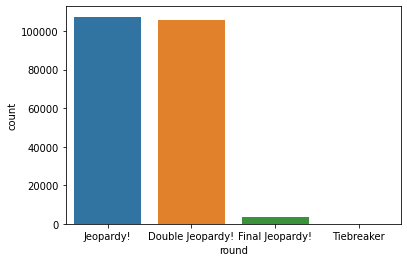

In [89]:
sns.countplot(data['round'])

In [90]:
data['value']=np.where((data['round']=='Final Jeopardy!') |( data['round']=='Tiebreaker'), 'None', data['value'])
data=data[data['value']!= 'None']
data.shape

(213296, 7)

In [91]:
data.head()

,show_number,air_date,round,category,value,question,answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [92]:
data['value']=data['value'].apply(
    lambda value: int(value.replace('$', '').replace(',','')))

In [93]:
def bining(val):
  if val < 1000:
    return np.round(val,-2)
  elif val < 10000:
    return np.round(val,-3)
  else:
    return np.round(val,-4)

data.value=data.value.apply(bining)
    

In [50]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wordnet=WordNetLemmatizer()
from tqdm import tqdm

In [51]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [59]:
corpus = []
for i in tqdm(data['question']):
    q = re.sub('[^A-Za-z0-9]+', ' ', i)
    #q = q.replace('\\r', ' ')
    #q = q.replace('\\"', ' ')
    #q = q.replace('\\n', ' ')
    q = q.lower().strip()
    #q = q.split('')
    q = [wordnet.lemmatize(word) for word in q.split() if not word in set(stopwords.words('english'))]
    q = '  '.join(q)
    corpus.append(q)

100%|██████████| 213296/213296 [04:32<00:00, 783.55it/s]


In [ ]:
"""from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(corpus) 
                     
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() """

In [94]:
data['question']=corpus
#data.drop(['air_date'],axis=1,inplace=True)
data.head()

,show_number,air_date,round,category,value,question,answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200,last year life galileo hous arrest espou...,Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,olympian footbal star carlisl indian scho...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,citi yuma state record averag hour sunsh...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,live art linklett show compani serv bill...,McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,signer dec indep framer constitut mass s...,John Adams


In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

"""data['question']=tfidf.fit_transform(data['question'])
data['round']=tfidf.fit_transform(data['round'])"""

"data['question']=tfidf.fit_transform(data['question'])\ndata['round']=tfidf.fit_transform(data['round'])"

In [109]:
x=data['question']
y=data['value']


In [110]:
from sklearn.model_selection import train_test_split
x_train,y_train,x_test,y_test=train_test_split(x,y,random_state=42,test_size=0.25)

In [ ]:
x_train=tfidf.fit_transform(x_train)
x_train=x_train.toarray()
y_train=tfidf.fit_transform(y_train)
y_train=y_train.toarray()

In [107]:
from sklearn.metrics import recall_score,precision_score,f1_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier

dt=DecisionTreeClassifier(criterion='gini',random_state=1)
dt.fit(x_train,y_train)
pred=dt.predict(x_test)

# Find Accuracy using accuracy_score method
dt_accuracy =metrics.accuracy_score(y_test, pred)
dt_recall=recall_score(y_test, pred)
dt_precision=precision_score(y_test, pred)
dt_f1score=f1_score(y_test, pred)
dt_auc = roc_auc_score(y_test,pred)
print('dt_roc_auc_score : ',dt_auc)
print('dt_accuracy : ',dt_accuracy)
print('dt_recall : ',dt_recall)
print('dt_precision : ',dt_precision)
print('dt_f1score : ',dt_f1score)

TypeError: ignored

In [74]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(criterion = 'entropy',random_state=1)
rt=rf.fit(x_train,y_train)
pred=rf.predict(x_test)

# Find Accuracy using accuracy_score method
rf_accuracy = metrics.accuracy_score(y_test, pred)
rf_recall=recall_score(y_test, pred)
rf_precision=precision_score(y_test, pred)
rf_f1score=f1_score(y_test, pred)
rf_auc = roc_auc_score(y_test,pred)
"""print('rf_roc_auc_score : ',rf_auc)
print('rf_accuracy : ',rf_accuracy)
print('rf_recall : ',rf_recall)
print('rf_precision : ',rf_precision)
print('rf_f1score : ',rf_f1score) """

ValueError: ignored

In [75]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(x_train,y_train)
pred=nb.predict(x_test)

# Find Accuracy using accuracy_score method
nb_accuracy =metrics.accuracy_score(y_test, pred)
nb_recall=recall_score(y_test, pred)
nb_precision=precision_score(y_test, pred)
nb_f1score=f1_score(y_test, pred)
nb_auc = roc_auc_score(y_test,pred)
"""print('nb_roc_auc_score : ',nb_auc)
print('nb_accuracy : ',nb_accuracy)
print('nb_recall : 'nb_recall)
print('nb_precision : ',nb_precision)
print('nb_f1score : ',nb_f1score)"""

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: ignored

In [76]:
from xgboost import XGBClassifier
xgb = XGBClassifier(criterion='gini',max_depth=5, n_estimators=50)
xgb.fit(x_train, y_train)
pred=xgb.predict(x_test)

# Find Accuracy using accuracy_score method
xgb_accuracy = metrics.accuracy_score(y_test, pred) 
xgb_recall=recall_score(y_test, pred)
xgb_precision=precision_score(y_test, pred)
xgb_f1score=f1_score(y_test, pred)
xgb_auc = roc_auc_score(y_test,pred)
"""print('xgb_roc_auc_score : ',xgb_auc)
print('xgb_accuracy : ',xgb_accuracy)
print('xgb_recall : ',xgb_recall)
print('xgb_precision : ',xgb_precision)
print('xgb_f1score : ',xgb_f1score)"""

ValueError: ignored

In [77]:
!pip install catboost
from catboost import CatBoostClassifier
cb = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1)
cb.fit(x_train, y_train)
pred=cb.predict(x_test)

# Find Accuracy using accuracy_score method
cb_accuracy = metrics.accuracy_score(y_test, pred) 
cb_recall=recall_score(y_test, pred)
cb_precision=precision_score(y_test, pred)
cb_f1score=f1_score(y_test, pred)
cb_auc = roc_auc_score(y_test,pred)
"""print('cb_roc_auc_score : ',cb_auc)
print('cb_accuracy : ',cb_accuracy)
print('cb_recall : ',cb_recall)
print('cb_precision : ',cb_precision)
print('cb_f1score : ',cb_f1score)"""

     |████████████████████████████████| 67.3MB 54kB/s 


CatBoostError: ignored

In [ ]:
Model_Comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest','CatBoostClassifier','Naive Bayes','XGBClassifier'],
    'Accuracy': [dt_accuracy, rf_accuracy, nb_accuracy, cb_accuracy, xgb_accuracy],
    'roc_auc_score': [ dt_auc, rf_auc, nb_auc, cb_auc, xgb_auc],
    'F1_score':[dt_f1score , rf_f1score, nb_f1score, cb_f1score, xgb_f1score]})

Model_Comparison_df = Model_Comparison.sort_values(by='roc_auc_score', ascending=False)
Model_Comparison_df = Model_Comparison_df.set_index('Model')
Model_Comparison_df.reset_index()